In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import sklearn.cluster as sk_cluster
import sklearn.feature_extraction.text as sk_text
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage      

%matplotlib inline
pd.set_option('display.max_colwidth', -1)

In [2]:
cleaned_data = pd.read_csv('cleaned_data.csv')
clinton_trump_texts = pd.read_table('clinton_trump_user_classes.txt', names = ['UserID', 'Class'], sep='\t')

In [3]:
clinton_trump_texts_agg = cleaned_data.groupby('UserID')['Hash'].apply(" ".join)
clinton_trump_sklearn = pd.DataFrame({'User_id':clinton_trump_texts_agg.index,'All_hashtag':clinton_trump_texts_agg.values})

In [4]:
vectorizer = sk_text.TfidfVectorizer(stop_words='english',max_features=5000, min_df=1, max_df=300)
matrix = vectorizer.fit_transform(clinton_trump_sklearn.All_hashtag.values)
tfidf = matrix.toarray()

In [5]:
df = pd.DataFrame(matrix.todense(),index = clinton_trump_texts_agg.index, columns = vectorizer.get_feature_names())

In [6]:
merged_df = pd.merge(df,clinton_trump_texts, on='UserID')

## Task 1.1

### Let’s apply clustering and compare the clustering result against a known ground truth. In the file “clinton_trump_user_classes.txt”, we have the ground truth “class” membership for each user id in the data. Class 0 corresponds to Trump followers, while class 1 corresponds to Clinton followers.

### Run the k-means algorithm (K=2) and the two different variations of the agglomerative clustering algorithm (MAX-based and SSE-based).

### Compute the confusion matrix, precision, recall, and F-measure for (1) k-means, (2) MAX-based agglomerative clustering, and (3) SSE-based agglomerative clustering. Compare their performance and include your conclusions in your report. See sample code in lab 4.

## K-means

In [7]:
%%time
kmeans = sk_cluster.KMeans(n_clusters=2, n_init=10, max_iter=300)
kmeans_label = kmeans.fit_predict(tfidf)

Wall time: 1min 19s


In [8]:
print ('\nPrinting cluster assignment:')
print(kmeans_label)


Printing cluster assignment:
[0 0 0 ... 0 0 0]


In [9]:
print('\n')
error = kmeans.inertia_       #SSE; Sum of squared distances of samples to their closest cluster center.
print ("The total error of the clustering is: ", error)



The total error of the clustering is:  8500.5937459524


In [10]:
truth = np.array(merged_df.Class.values)
truth

array([1, 0, 0, ..., 1, 1, 1], dtype=int64)

In [11]:
confusion = metrics.confusion_matrix(truth, kmeans.labels_, labels=[0, 1])   # first row: 0 ; second row: 1
print(confusion)
print(metrics.precision_score(truth, kmeans.labels_, average='weighted'))
print(metrics.recall_score(truth, kmeans.labels_, average='weighted'))
print(metrics.f1_score(truth, kmeans.labels_, average= 'weighted'))

[[4523   81]
 [4261   56]]
0.4635438623747708
0.5132832642080484
0.3608770772556578


## Agglomerative Clustering

### MAX based

In [12]:
%%time
ag1 = sk_cluster.AgglomerativeClustering(linkage = 'complete', n_clusters = 2) 

Wall time: 0 ns


In [13]:
ag_labels = ag1.fit_predict(tfidf)

In [14]:
print ('\nPrinting cluseter assignment:')
ag_labels


Printing cluseter assignment:


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [15]:
confusion = metrics.confusion_matrix(truth, ag1.labels_, labels=[0, 1])   # first row: 0 ; second row: 1
print(confusion)
print(metrics.precision_score(truth, ag1.labels_, average='weighted'))
print(metrics.recall_score(truth, ag1.labels_, average='weighted'))
print(metrics.f1_score(truth, ag1.labels_, average= 'weighted'))

[[4598    6]
 [4293   24]]
0.6540262997368862
0.5181033516421926
0.35702357436394166


### SSE based

In [16]:
ag2 = sk_cluster.AgglomerativeClustering(linkage = 'ward', n_clusters = 2)   

In [17]:
ag_labels2 = ag2.fit_predict(merged_df)

In [18]:
print ('\nPrinting cluseter assignment:')
ag_labels2 


Printing cluseter assignment:


array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [19]:
confusion = metrics.confusion_matrix(truth, ag2.labels_, labels=[0, 1])   # first row: 0 ; second row: 1
print(confusion)
print(metrics.precision_score(truth, ag2.labels_, average='weighted'))
print(metrics.recall_score(truth, ag2.labels_, average='weighted'))
print(metrics.f1_score(truth, ag2.labels_, average= 'weighted'))

[[2220 2384]
 [1291 3026]]
0.5969901995123185
0.5880506669655868
0.583453062904208


## Task 1.2

### For k-means, look at the two centers (centroids) and print the top-30 hashtags/handles with the highest tfidf values.

In [20]:
centroids = kmeans.cluster_centers_
print ('Cluster Centroids')
print(centroids)

Cluster Centroids
[[ 7.16327624e-04  4.72736992e-03  5.68170491e-04 ...  4.33622766e-04
   4.02177272e-04  2.02894409e-05]
 [ 5.24323828e-04 -6.93889390e-18  0.00000000e+00 ... -3.79470760e-19
  -6.50521303e-19  0.00000000e+00]]


In [21]:
asc_order_centroids = kmeans.cluster_centers_.argsort()    # argsort() returns the indices that would sort an array.
des_order_centroids = asc_order_centroids[:,::-1] 
print(asc_order_centroids)

[[3023 3551 1475 ...  660 3624 3604]
 [3624 2318  660 ... 3022 1324 3021]]


In [22]:
terms = np.array(vectorizer.get_feature_names())
print ("All the terms:")
print(terms, '\n')
x = []
y = []

for i in range(2):
    print ("Cluster:", i)
    for ind in des_order_centroids[i, :30]:
        if (i == 0):
            x.append(terms[ind])
        else:
            y.append(terms[ind])
        print (terms[ind])
    print()  

All the terms:
['039' '0hour1__' '0hour1___' ... 'zip90210' 'znation' 'zolemica2'] 

Cluster: 0
quote
rallytogether
c0nvey
trump2016
lockherup
foxandfriends
0hour1__
mailonline
hrc
hillarysemail
morning_joe
mcuban
frankluntz
maga3x
hillarysemails
yahoonews
lindasuhler
amjoyshow
hiac
thewalkingdead
tcot
dineshdsouza
voxdotcom
keitholbermann
jackposobiec
joenbc
huffingtonpost
guardian
noltenc
npr

Cluster: 1
mplusplaces
ebay
mplusrewards
flythew
gocubsgo
letsgo
hiac
cricketrewards
kschwarb12
mpoints
letsgocubs
cubsvsindians
etsy
mplaces
razzlepuzzles
mewlisoftware
sarahspain
gocubs
leafyishere
app
dictionarycom
att
rmhc
mcdonalds
espnchicubs
subway
christmas
vintage
mlbonfox
buck



## Task 1.3

### Show the two respective word clouds of the two centers (centroids) by using hashtags/handles and their tfidf values. Hint: Use function fit_words() that comes with wordcloud

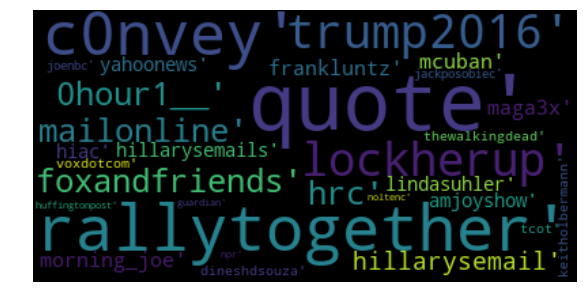

In [23]:
wordcloud = WordCloud().generate(str(x))
plt.figure(figsize=(12,5))
plt.imshow(wordcloud, interpolation='bilinear')  #  bilinear interpolation performs linear interpolation in 2D space. 
plt.axis("off")
plt.show()

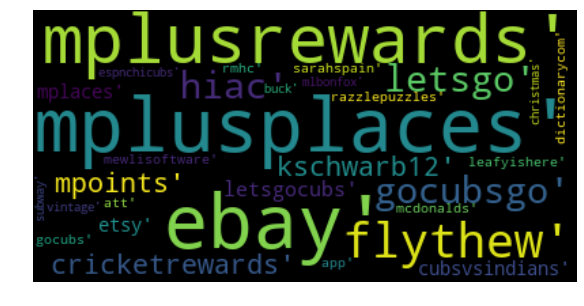

In [24]:
wordcloud = WordCloud().generate(str(y))
plt.figure(figsize=(12,5))
plt.imshow(wordcloud, interpolation='bilinear')  #  bilinear interpolation performs linear interpolation in 2D space. 
plt.axis("off")
plt.show()

# 2. Clustering of Hashtags/handles

## Task 2.1

### First, you apply the k-means algorithm. Create a plot of the SSE error of the k-means algorithm as a function of the number of clusters, for k up to 20, in order to determine the optimal number of clusters.

Text(0, 0.5, 'SSE')

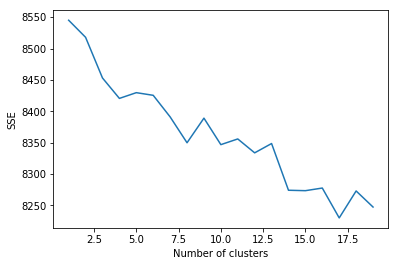

In [25]:
error = np.zeros(20)
for k in range(1,20):
    kmeans = sk_cluster.KMeans(n_clusters=k, n_init=10, max_iter=500)
    kmeans.fit_predict(tfidf.transpose())
    error[k] = kmeans.inertia_

plt.plot(range(1, 20), error[1:])
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

## Task 2.2

### Run the k-means algorithm for the optimal number of clusters you identified in the last task. Print some hashtags/handles in each cluster. From the hashtags/handles in each cluster, try to deduce what is the topic it concerns. Include your conclusions in your report.

In [26]:
kmeans = sk_cluster.KMeans(n_clusters=3, n_init=10, max_iter=300)
kmeans_label = kmeans.fit_predict(tfidf)

In [27]:
print ('\nPrinting cluster assignment:')
print(kmeans_label)


Printing cluster assignment:
[0 0 0 ... 0 0 0]


In [28]:
print('\n')
error = kmeans.inertia_       #SSE; Sum of squared distances of samples to their closest cluster center.
print ("The total error of the clustering is: ", error)



The total error of the clustering is:  8421.901324778426


In [29]:
truth = np.array(merged_df.Class.values)
truth

array([1, 0, 0, ..., 1, 1, 1], dtype=int64)

In [30]:
confusion = metrics.confusion_matrix(truth, kmeans.labels_, labels=[0, 1])   # first row: 0 ; second row: 1
print(confusion)
print("Precision Score: ")
print(metrics.precision_score(truth, kmeans.labels_, average='weighted')) # weighted: the average precision of all clusters is returned
print("Recall Score: ")
print(metrics.recall_score(truth, ag2.labels_, average='weighted'))  # weighted: the average recall of all clusters is returned
print("F1 Score: ")
print(metrics.f1_score(truth, ag2.labels_, average= 'weighted'))     # weighted: the average f1 of all clusters is returned


[[2882 1667]
 [4187   73]]
Precision Score: 
0.2307079847244885
Recall Score: 
0.5880506669655868
F1 Score: 
0.583453062904208


In [31]:
asc_order_centroids = kmeans.cluster_centers_.argsort()    # argsort() returns the indices that would sort an array.
des_order_centroids = asc_order_centroids[:,::-1] 
print(asc_order_centroids)

[[3728  850  766 ...  660 1539 3624]
 [3604 3601 2062 ... 1566 4581 2683]
 [3624 2318 2422 ... 2794  660 3604]]


In [32]:
terms = np.array(vectorizer.get_feature_names())
print ("All the terms:")
print(terms, '\n')

for i in range(3):
    print ("Cluster:", i)
    for ind in des_order_centroids[i, :30]:
        print (terms[ind])
    print() 

All the terms:
['039' '0hour1__' '0hour1___' ... 'zip90210' 'znation' 'zolemica2'] 

Cluster: 0
rallytogether
flythew
c0nvey
hiac
mplusplaces
ebay
thewalkingdead
amjoyshow
keitholbermann
hrc
mlb
guardian
morning_joe
mattyglesias
giveaway
voxdotcom
npr
midnight
espn
thefix
nba
samsteinhp
lawrence
vote
appleevent
huffingtonpost
joenbc
tpm
strongertogether
slate

Cluster: 1
lockherup
trump2016
foxandfriends
0hour1__
maga3x
lindasuhler
hillarysemail
gatewaypundit
frankluntz
noltenc
dineshdsouza
votetrump
mailonline
8217
asamjulian
jackposobiec
hillarysemails
thefive
lorettalynch
anncoulter
foxbusiness
mcuban
lifezette
kellyfile
darren32895836
msm
worldnetdaily
michaelcohen212
hillaryemails
greta

Cluster: 2
quote
c0nvey
marketing
socialmedia
leadership
entrepreneur
startup
wednesdaywisdom
inspiration
tweetjukebox
mlm
jmteam
linkedin
scarystoriesin5words
success
music
bpolitics
podestaemails19
image
taylorswift13
salon
contentmarketing
tedtalks
officialjimrohn
cnnmoney
emabiggestfansjustinb